# 필요 라이브러리 import

In [1]:
import pandas as pd                                          #데이터 분석 라이브러리
from sklearn.decomposition import PCA                        #주성분 분석 라이브러리
import numpy as np                                           # 계산 라이브러리
from sklearn.preprocessing import MinMaxScaler,MaxAbsScaler  # 최소 최대 0~1 범위로 변환을 위한 라이브러리

from sklearn.model_selection import train_test_split         # 데이터 분할 라이브러리
from sklearn.model_selection import cross_validate           # Kfold 라이브러리
from sklearn.model_selection import cross_val_score          # Kfold 라이브러리
from sklearn.model_selection import StratifiedKFold          # Kfold 라이브러리


from sklearn.neighbors import KNeighborsClassifier           # KNN 라이브러리
from sklearn.svm import SVC                                  # SVM Classifier 라이브러리
from sklearn.tree import DecisionTreeClassifier              # 결정나무분류 라이브러리
from sklearn.linear_model import LogisticRegression          # 로지스틱 회귀 라이브러리
from bayes_opt import BayesianOptimization                   # 베이시안 라이브러리   


from sklearn.metrics import make_scorer                      # 평가용 라이브러리
from sklearn.metrics import f1_score                         # f1  라이브러리
from sklearn.metrics import accuracy_score                   # accuracy 라이브러리 



import matplotlib.pyplot as plt                              # 그래프 라이브러리
from sklearn.ensemble import VotingClassifier                # 보팅 앙상블 라이브러리
import seaborn as sns                                        # boxplot 을 위한 라이브러리

# data 불러오기

In [6]:
File = pd.read_csv("../../Data/final_data/training/geo_data/geo_training_data.csv")

In [7]:
File.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 796 entries, 0 to 795
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Hourly_Rainfall_Weight     796 non-null    float64
 1   Impervious_Surface_Weight  796 non-null    float64
 2   SLOPE_AVG_Weight           796 non-null    float64
 3   HIGH_Weight                796 non-null    float64
 4   F_WEIGHT                   796 non-null    float64
 5   FLOOD                      796 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 37.4 KB


In [8]:
Floodfile = File.drop(['FLOOD'], axis = 1)
Floodclass = File['FLOOD']

In [9]:
Floodfile

,Hourly_Rainfall_Weight,Impervious_Surface_Weight,SLOPE_AVG_Weight,HIGH_Weight,F_WEIGHT
0,0.076087,0.955239,0.599952,0.024868,0.149925
1,0.184783,0.955239,0.599952,0.024868,0.149925
2,0.254902,0.955239,0.599952,0.024868,0.149925
3,0.443182,0.955239,0.599952,0.024868,0.149925
4,0.076087,0.460742,2.699784,0.039186,0.075019
...,...,...,...,...,...
791,0.259722,0.609000,0.599952,0.022231,0.075019
792,0.208696,0.609000,0.599952,0.014820,0.075019
793,0.259722,0.609000,0.599952,0.014820,0.075019
794,0.208696,0.609000,0.599952,0.019719,0.075019


# minmaxscaler
## data scale 과정

In [10]:
scaler = MinMaxScaler()
scaler.fit(Floodfile)
Floodfile = scaler.transform(Floodfile)

# PCA

In [11]:
pca = PCA(n_components=4) # 주성분을 몇개로 할지 결정
printcipalComponents = pca.fit_transform(Floodfile)
Floodfile = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2','principal component3', 'principal component4'])

In [12]:
Floodfile

,principal component1,principal component2,principal component3,principal component4
0,0.849578,-0.070940,0.203118,0.172587
1,0.840140,0.023789,0.049162,0.116944
2,0.834052,0.084898,-0.050155,0.081049
3,0.817703,0.248985,-0.316834,-0.015334
4,0.108023,-0.292083,0.200267,-0.075060
...,...,...,...,...
791,0.195729,-0.151192,-0.133485,-0.015557
792,0.200161,-0.195663,-0.061212,0.010564
793,0.195730,-0.151193,-0.133486,-0.015557
794,0.200160,-0.195662,-0.061212,0.010564


# data split
## 8 : 2 으로 training 과 test 구분

In [13]:
x_train, x_test, y_train, y_test = train_test_split(Floodfile, Floodclass , test_size=0.2, random_state=400)

In [14]:
skfolds=StratifiedKFold(n_splits=5, random_state=400 ,shuffle = True)

# BayesianOptimization

## KNN

In [15]:
KNN_search_point = {'k': (3,50), 'leaf': (1,50)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
leaf_all=[]

def KNN_opt(k,leaf):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
#         print(train_index)
#         print(val_index)
        x_skftrain, x_val = x_train.values[train_index], x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]
        KNNmodel = KNeighborsClassifier(n_neighbors = int(k),weights = 'distance', leaf_size= leaf ) # KNN  
        
        KNNmodel2 = KNNmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = KNNmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
#         report = accuracy_score(Y_val, y_pred)             # accuracy
        cvscores.append(report)
    
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
#     leaf_all.append(int(leaf))
    
    return np.mean(cvscores)

result = BayesianOptimization(KNN_opt, KNN_search_point,    random_state=10,    verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |     k     |   leaf    |
-------------------------------------------------
|  1        |  0.7996   |  39.25    |  2.017    |
|  2        |  0.8012   |  26.48    |  25.79    |
|  3        |  0.7961   |  49.83    |  49.36    |
|  4        |  0.7875   |  3.055    |  1.341    |
|  5        |  0.8027   |  30.53    |  23.87    |
|  6        |  0.7961   |  50.0     |  19.96    |
|  7        |  0.8012   |  26.77    |  8.533    |
|  8        |  0.8012   |  27.17    |  21.02    |
|  9        |  0.8012   |  27.38    |  49.95    |
|  10       |  0.8011   |  36.51    |  39.72    |
|  11       |  0.7892   |  3.021    |  49.96    |
|  12       |  0.8012   |  26.68    |  1.095    |
|  13       |  0.7996   |  37.1     |  18.1     |
|  14       |  0.7961   |  49.83    |  1.949    |
|  15       |  0.7996   |  37.42    |  29.99    |
|  16       |  0.8027   |  31.61    |  19.22    |


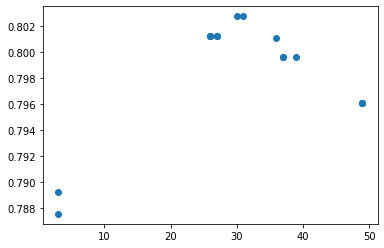

In [16]:
plt.scatter(k_all, scores_all)

## SVM

In [17]:
SVM_search_point = {'k': (1,30), 'gamma': (0.001,20)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
gamma_all = []
def SVM_opt(k,gamma):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        SVMmodel = SVC( C= int(k) , kernel='rbf' , probability = True, gamma = gamma ) # SVM  
        
        SVMmodel2 = SVMmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = SVMmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
#         report = accuracy_score(Y_val, y_pred)             # accuracy
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    return np.mean(cvscores)

result = BayesianOptimization(SVM_opt, SVM_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=20, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |   gamma   |     k     |
-------------------------------------------------
|  1        |  0.7599   |  15.43    |  1.602    |
|  2        |  0.7631   |  9.991    |  15.67    |
|  3        |  0.7891   |  19.93    |  29.62    |
|  4        |  0.7891   |  19.96    |  29.95    |
|  5        |  0.7838   |  19.93    |  21.86    |
|  6        |  0.7598   |  0.3358   |  29.86    |
|  7        |  0.4857   |  0.01901  |  1.612    |
|  8        |  0.7534   |  9.991    |  29.96    |
|  9        |  0.7624   |  19.95    |  1.171    |
|  10       |  0.7594   |  19.98    |  9.715    |
|  11       |  0.7433   |  0.1069   |  22.93    |
|  12       |  0.7599   |  14.74    |  21.79    |
|  13       |  0.7858   |  19.98    |  26.39    |
|  14       |  0.7628   |  13.76    |  9.731    |
|  15       |  0.7776   |  19.98    |  17.18    |
|  16       |  0.7792   |  17.56    |  29.96    |
|  17       |  0.7891   |  19.99    |  29.24    |
|  18       |  0.7891   |  19.89    |  29.78    |


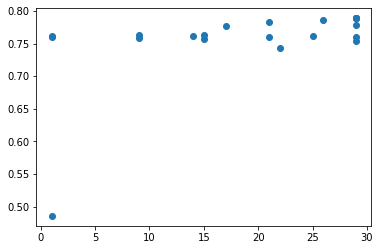

In [18]:
plt.scatter(k_all, scores_all)

## Decision Tree

In [19]:
DT_search_point = { 'k': (1,30), 'leaf' : ( 2, 30), 'split': (2,30) }

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []
leaf_all = []
split_all = []

def DT_opt(k,leaf,split):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        DTmodel = DecisionTreeClassifier(criterion='gini',
                                         max_depth=int(k),              # 트리의 최대 깊이
                                         min_samples_leaf= int(leaf),
                                         min_samples_split= int(split)) #DT  
        
        
        DTmodel2 = DTmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = DTmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
#         report = accuracy_score(Y_val, y_pred)             # accuracy
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    leaf_all.append(int(leaf))
    split_all.append(split)

    
    return np.mean(cvscores)

result = BayesianOptimization(DT_opt, DT_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |     k     |   leaf    |   split   |
-------------------------------------------------------------
|  1        |  0.7838   |  23.37    |  2.581    |  19.74    |
|  2        |  0.7708   |  26.25    |  23.01    |  19.33    |
|  3        |  0.6655   |  1.0      |  2.0      |  2.0      |
|  4        |  0.6655   |  1.0      |  2.0      |  30.0     |
|  5        |  0.7643   |  30.0     |  2.0      |  2.0      |
|  6        |  0.7906   |  29.75    |  4.723    |  29.89    |
|  7        |  0.7375   |  28.11    |  29.53    |  2.346    |
|  8        |  0.7892   |  28.3     |  3.846    |  27.2     |
|  9        |  0.7375   |  29.51    |  29.47    |  28.71    |
|  10       |  0.6655   |  1.64     |  29.8     |  8.813    |
|  11       |  0.7724   |  29.91    |  8.337    |  14.7     |
|  12       |  0.7745   |  19.21    |  15.9     |  29.81    |
|  13       |  0.7898   |  24.65    |  2.698    |  29.75    |
|  14       |  0.784    |  26.27    |  9.833    |  29.44    |
|  15   

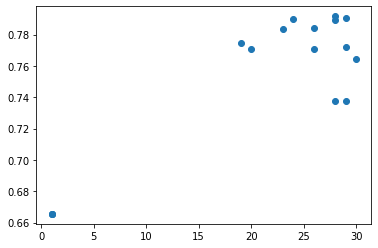

In [20]:
plt.scatter(k_all, scores_all)

## Logistic Regression

In [21]:
LR_search_point = { 'k': (1,30)}

gp_params = {"alpha":1e-10}
scores_all = []
k_all = []

def LR_opt(k):
    cvscores = []
    
    for train_index, val_index in skfolds.split(x_train, y_train):
        x_skftrain, x_val = x_train.values[train_index],x_train.values[val_index]
        Y_skftrain, Y_val = np.array(y_train)[train_index],np.array(y_train)[val_index]

        LRmodel = LogisticRegression(C= int(k) , multi_class= 'auto') #LR  
        
        
        LRmodel2 = LRmodel.fit(x_skftrain,Y_skftrain)      # 모델학습
        y_pred = LRmodel2.predict(x_val)                    # 예측

        report = f1_score(Y_val, y_pred, average='weighted') # F1
#         report = accuracy_score(Y_val, y_pred)             # accuracy
        cvscores.append(report)
    
    scores_all.append(np.mean(cvscores))
    k_all.append(int(k))
    
    return np.mean(cvscores)

result = BayesianOptimization(LR_opt, LR_search_point, random_state=10, verbose=2) 
result.maximize(acq='ucb',n_iter=15, kappa=2.576, init_points=1 , **gp_params)

|   iter    |  target   |     k     |
-------------------------------------
|  1        |  0.7199   |  23.37    |
|  2        |  0.7181   |  11.49    |
|  3        |  0.7199   |  29.98    |
|  4        |  0.7199   |  26.21    |
|  5        |  0.7199   |  28.4     |
|  6        |  0.7199   |  26.07    |
|  7        |  0.7199   |  29.3     |
|  8        |  0.7199   |  21.48    |
|  9        |  0.7199   |  28.65    |
|  10       |  0.7199   |  23.61    |
|  11       |  0.7199   |  25.48    |
|  12       |  0.7199   |  28.78    |
|  13       |  0.7199   |  26.94    |
|  14       |  0.7199   |  23.05    |
|  15       |  0.7199   |  25.99    |
|  16       |  0.7199   |  23.9     |


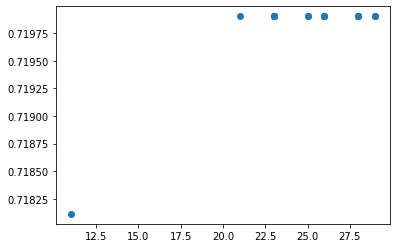

In [22]:
plt.scatter(k_all, scores_all)

# Voting ensemble
## 사용 된 모델 : KNN, SVM, Decision Tree, Logistic Regression

In [23]:
KNN_model = KNeighborsClassifier(n_neighbors = 21,weights = 'distance')

SVM_model = SVC( C= 20 , kernel='rbf' , probability = True , gamma = 20 )

DT_model = DecisionTreeClassifier(criterion='gini', max_depth=29, min_samples_leaf= 2, min_samples_split= 10)

LR_model = LogisticRegression(C= 12, multi_class= 'auto')

In [24]:
ensemble=VotingClassifier(
        estimators=[('KNN',KNN_model),
                   ('SVM',SVM_model),
                   ('DT',DT_model),
                   ('LR',LR_model)]
        ,voting='soft')

# Voting 모델 안에 각 모델들을 묶어주기

In [25]:
KNN_model.fit(x_train,y_train)
SVM_model.fit(x_train,y_train)
DT_model.fit(x_train,y_train)
LR_model.fit(x_train,y_train)
ensemble.fit(x_train,y_train)

# 각 모델들을 데이터로 학습시키기

VotingClassifier(estimators=[('KNN',
                              KNeighborsClassifier(algorithm='auto',
                                                   leaf_size=30,
                                                   metric='minkowski',
                                                   metric_params=None,
                                                   n_jobs=None, n_neighbors=21,
                                                   p=2, weights='distance')),
                             ('SVM',
                              SVC(C=20, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma=20, kernel='rbf', max_iter=-1,
                                  probability=True, random_...
                                                     presort='deprecated',
                                                     random_state=None

# 교차검증 적용

In [26]:
SKF = StratifiedKFold( n_splits = 5,  shuffle = True, random_state = 16)

In [27]:
KNN_scores=cross_validate(KNN_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
SVM_scores=cross_validate(SVM_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
DT_scores=cross_validate(DT_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
LR_scores=cross_validate(LR_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
ensemble_scores=cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))

In [28]:
print(KNN_scores)
print(SVM_scores)
print(DT_scores)
print(LR_scores)
print(ensemble_scores)

{'fit_time': array([0.00292206, 0.00147462, 0.00194788, 0.00198197, 0.00194788]), 'score_time': array([0.00294876, 0.00292253, 0.00299215, 0.0029192 , 0.00291848]), 'test_score': array([0.65263158, 0.68131868, 0.68085106, 0.74468085, 0.75268817])}
{'fit_time': array([0.0585916 , 0.05164671, 0.0574162 , 0.05540967, 0.05618405]), 'score_time': array([0.0039053 , 0.0019536 , 0.00297832, 0.0019486 , 0.00194693]), 'test_score': array([0.6741573 , 0.72897196, 0.74747475, 0.75      , 0.76      ])}
{'fit_time': array([0.00291944, 0.00194669, 0.00201917, 0.00290871, 0.00362968]), 'score_time': array([0.00097346, 0.00097632, 0.00203538, 0.0019412 , 0.00089669]), 'test_score': array([0.60674157, 0.7032967 , 0.70707071, 0.73333333, 0.65909091])}
{'fit_time': array([0.00443292, 0.0040102 , 0.00488067, 0.00535321, 0.00873947]), 'score_time': array([0.00098324, 0.00096774, 0.00197601, 0.00203395, 0.00204992]), 'test_score': array([0.58536585, 0.47058824, 0.63529412, 0.69767442, 0.62650602])}
{'fit_ti

In [29]:
KNN_f1_score = KNN_scores["test_score"].mean()
SVN_f1_score = SVM_scores["test_score"].mean()
DT_f1_score = DT_scores["test_score"].mean()
LR_f1_score = LR_scores["test_score"].mean()
ensemble_f1_score = ensemble_scores["test_score"].mean()


print("f1_score: {0: .4f}".format(KNN_f1_score))
print("f1_score: {0: .4f}".format(SVN_f1_score))
print("f1_score: {0: .4f}".format(DT_f1_score))
print("f1_score: {0: .4f}".format(LR_f1_score))
print("f1_score: {0: .4f}".format(ensemble_f1_score))

f1_score:  0.7024
f1_score:  0.7321
f1_score:  0.6819
f1_score:  0.6031
f1_score:  0.7081


# 결과 boxplot

## KNN

[Text(1, 0, 'KNN')]

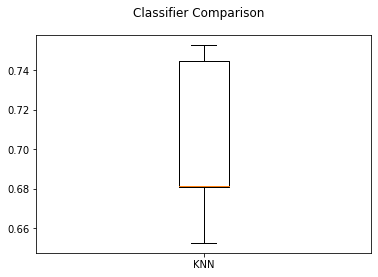

In [30]:
results = []
names = []

models = []
models.append(('KNN', KNN_model))


for name, model in models:
    kfold = StratifiedKFold( n_splits = 5,  shuffle = True, random_state = 10)
#     cv_results = cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    cv_results = cross_val_score(KNN_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    
    results.append(cv_results)
    names.append(name)
    
fig = plt.figure()
fig.suptitle('Classifier Comparison')
ax= fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

## SVM

[Text(1, 0, 'SVM')]

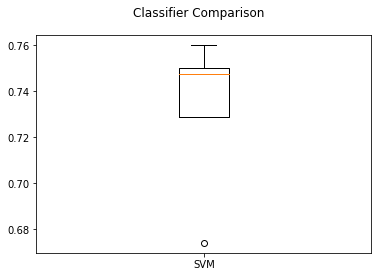

In [31]:
results = []
names = []

models = []

models.append(('SVM', SVM_model))


for name, model in models:
    kfold = StratifiedKFold( n_splits = 5,  shuffle = True, random_state = 10)
#     cv_results = cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    cv_results = cross_val_score(SVM_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    
    results.append(cv_results)
    names.append(name)
    
fig = plt.figure()
fig.suptitle('Classifier Comparison')
ax= fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

## Decision Tree

[Text(1, 0, 'DT')]

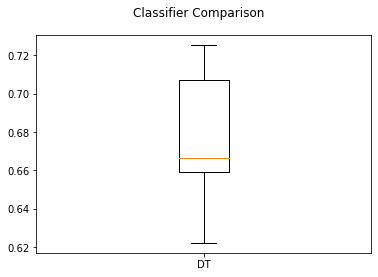

In [32]:
results = []
names = []

models = []
models.append(('DT', DT_model))


for name, model in models:
    kfold = StratifiedKFold( n_splits = 5,  shuffle = True, random_state = 10)
#     cv_results = cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    cv_results = cross_val_score(DT_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    
    results.append(cv_results)
    names.append(name)
    
fig = plt.figure()
fig.suptitle('Classifier Comparison')
ax= fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

## Logistic regression

[Text(1, 0, 'LR')]

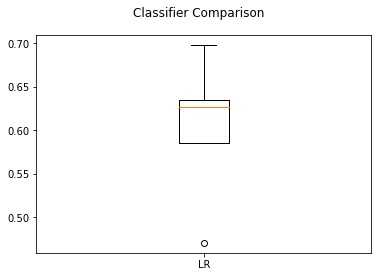

In [33]:
results = []
names = []

models = []
models.append(('LR', LR_model))


for name, model in models:
    kfold = StratifiedKFold( n_splits = 5,  shuffle = True, random_state = 10)
#     cv_results = cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    cv_results = cross_val_score(LR_model, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    
    results.append(cv_results)
    names.append(name)
    
fig = plt.figure()
fig.suptitle('Classifier Comparison')
ax= fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

## Voting ensemble

[Text(1, 0, 'Voting')]

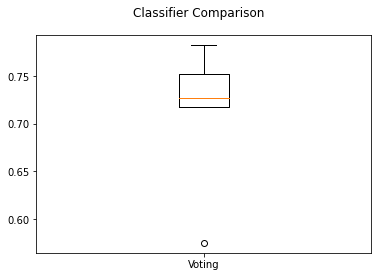

In [34]:
results = []
names = []

models = []
models.append(('Voting',ensemble))


for name, model in models:
    kfold = StratifiedKFold( n_splits = 5,  shuffle = True, random_state = 10)
#     cv_results = cross_validate(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    cv_results = cross_val_score(ensemble, x_train, y_train, cv=SKF, scoring=make_scorer(f1_score))
    
    results.append(cv_results)
    names.append(name)
    
fig = plt.figure()
fig.suptitle('Classifier Comparison')
ax= fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)

# test 데이터 예측 정확도

In [35]:
pred_KNN = KNN_model.predict(x_test)
pred_SVM = SVM_model.predict(x_test)
pred_DT = DT_model.predict(x_test)
pred_LR = LR_model.predict(x_test)

# 각 모델들의 f1_score 파악을 위해 모델들 예측실행

In [36]:
y_predict= ensemble.predict(x_test)

# 적용 모델인 Voting ensemble 예측

In [37]:
print('KNN',f1_score(y_test,pred_KNN))
print('SVM',f1_score(y_test,pred_SVM))
print('DT',f1_score(y_test,pred_DT))
print('LR',f1_score(y_test,pred_LR))
print('Voting',f1_score(y_test,y_predict))          # 각 모델들의 f1_Score 확인

KNN 0.6785714285714286
SVM 0.6371681415929203
DT 0.6666666666666665
LR 0.5490196078431372
Voting 0.6666666666666666


# 2020 년 사고사례 데이터

In [38]:
accident = pd.read_excel("초량동 지형 강우량.xlsx")   # 초량지하차도 지형정보 와 당일 시간당 강우량 데이터
accident

,SLOPE_L,SLOPE_H,SLOPE_AVG,HIGH,PUMP_RATIO,IMP_SUR_RATIO,MANHOLES_RATIO,HOUR_RAINFALL,F_WEIGHT,FLOOD,R_W_SUM,IMP_W_SUM
0,0,2,1,4,1.982160e-07,57.92,0.023885,0.0,0.017,0,0.000,3.99648
1,0,2,1,4,1.982160e-07,57.92,0.023885,0.0,0.017,0,0.000,3.99648
2,0,2,1,4,1.982160e-07,57.92,0.023885,0.0,0.017,0,0.000,3.99648
3,0,2,1,4,1.982160e-07,57.92,0.023885,0.0,0.017,0,0.000,3.99648
4,0,2,1,4,1.982160e-07,57.92,0.023885,0.5,0.017,0,0.005,3.99648
5,0,2,1,4,1.982160e-07,57.92,0.023885,0.0,0.017,0,0.000,3.99648
6,0,2,1,4,1.982160e-07,57.92,0.023885,0.0,0.017,0,0.000,3.99648
7,0,2,1,4,1.982160e-07,57.92,0.023885,1.0,0.017,0,0.010,3.99648
8,0,2,1,4,1.982160e-07,57.92,0.023885,3.5,0.017,0,0.035,3.99648
9,0,2,1,4,1.982160e-07,57.92,0.023885,0.0,0.017,0,0.000,3.99648


In [39]:
Busanaccident = accident.drop(['SLOPE_L','SLOPE_H','FLOOD','MANHOLES_RATIO'], axis = 1)  # 불필요 컬럼제거
Busanaccidentclass = accident['FLOOD']         

In [40]:
Busanaccident.rename(columns={'R_W_SUM':'Hourly_Rainfall_Weight','HOUR_RAINFALL':'Hourly_Rainfall','IMP_SUR_RATIO':'Impervious_Surface',
                              'IMP_W_SUM':'Impervious_Surface_Weight'},inplace=True)  # 컬럼명 수정

In [41]:
for idx,col in enumerate(Busanaccident['Hourly_Rainfall']):
    if col <= 15:
        Busanaccident['Hourly_Rainfall_Weight'][idx] = col / (46)
    elif col > 15 and col <= 35:
        Busanaccident['Hourly_Rainfall_Weight'][idx] = col / (18 * 2**2)
    elif col > 35 and col <= 60:
        Busanaccident['Hourly_Rainfall_Weight'][idx] = col / (17 * 3**2)
    elif col > 60 and col <= 80:
        Busanaccident['Hourly_Rainfall_Weight'][idx] = col / (11 * 4**2)
    elif col > 80:
        Busanaccident['Hourly_Rainfall_Weight'][idx] = col / (6.28 * 5**2)

c:\users\pcrmc\desktop\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\pcrmc\desktop\venv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\users\pcrmc\desktop\venv\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if _

In [42]:
for idx,col in enumerate(Busanaccident['Impervious_Surface']):
    if col <= 15:
        Busanaccident['Impervious_Surface_Weight'][idx] = col / 6.66
    elif col > 15 and col <= 25:
        Busanaccident['Impervious_Surface_Weight'][idx] = col / (20 * 2)
    elif col > 25 and col <= 40:
        Busanaccident['Impervious_Surface_Weight'][idx] = col / (13.33 * 3)
    elif col > 40 and col <= 55:
        Busanaccident['Impervious_Surface_Weight'][idx] = col / (33.33 * 4)
    elif col > 55:
        Busanaccident['Impervious_Surface_Weight'][idx] = col / (26.67 * 5)

c:\users\pcrmc\desktop\venv\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [43]:
Busanaccident['SLOPE_AVG_Weight'] = Busanaccident['SLOPE_AVG']

In [44]:
for idx,col in enumerate(Busanaccident['SLOPE_AVG']):
    if col <= 10:
        Busanaccident['SLOPE_AVG_Weight'][idx] = col / (41.67 / 5**2 )
    elif col > 10 and col <= 15:
        Busanaccident['SLOPE_AVG_Weight'][idx] = col / (25 / 4**2)
    elif col > 15 and col <= 25:
        Busanaccident['SLOPE_AVG_Weight'][idx] = col / (16.67 / 3**2)
    elif col > 25 and col <= 50:
        Busanaccident['SLOPE_AVG_Weight'][idx] = col / (8.33 / 2**2)
    elif col > 50:
        Busanaccident['SLOPE_AVG_Weight'][idx] = col / (8.33 / 1**2)

c:\users\pcrmc\desktop\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [45]:
Busanaccident['HIGH_Weight'] = Busanaccident['HIGH']

In [46]:
for idx,col in enumerate(Busanaccident['HIGH']):
    if col <= 20:
        Busanaccident['HIGH_Weight'][idx] = col / (79.62 / 1**2)
    elif col > 20 and col <= 40:
        Busanaccident['HIGH_Weight'][idx] = col / (10.18 / 2**2)
    elif col > 40 and col <= 60:
        Busanaccident['HIGH_Weight'][idx] = col / (4.63 / 3**2)
    elif col > 60 and col <= 80:
        Busanaccident['HIGH_Weight'][idx] = col / (2.78 / 4**2)
    elif col > 80:
        Busanaccident['HIGH_Weight'][idx] = col / (2.78 / 5**2)

c:\users\pcrmc\desktop\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [47]:
Busanaccident = Busanaccident.drop(['SLOPE_AVG','Impervious_Surface','Hourly_Rainfall','HIGH','PUMP_RATIO'], axis = 1)

In [48]:
Busanaccident

,F_WEIGHT,Hourly_Rainfall_Weight,Impervious_Surface_Weight,SLOPE_AVG_Weight,HIGH_Weight
0,0.017,0.000000,0.434346,0,0
1,0.017,0.000000,0.434346,0,0
2,0.017,0.000000,0.434346,0,0
3,0.017,0.000000,0.434346,0,0
4,0.017,0.010870,0.434346,0,0
5,0.017,0.000000,0.434346,0,0
6,0.017,0.000000,0.434346,0,0
7,0.017,0.021739,0.434346,0,0
8,0.017,0.076087,0.434346,0,0
9,0.017,0.000000,0.434346,0,0


In [49]:
scaler = MinMaxScaler()
scaler.fit(Busanaccident)
Busanaccident = scaler.transform(Busanaccident)                         # sccler 적용

In [50]:
pca = PCA(n_components=4)
printcipalComponents = pca.fit_transform(Busanaccident)
Busanaccident = pd.DataFrame(data=printcipalComponents, columns = ['principal component1', 'principal component2','principal component3', 'principal component4'])

In [51]:
accident_predict= ensemble.predict(Busanaccident)                       # 위에서 학습된 모델 활용을 이용한 예측

In [52]:
print(accident_predict)                                                 # 예측값 확인

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
